# Lab 3: Generative Models (Denoising Diffusion Probabilistic Model)
```
- [S25] Advanced Machine Learning, Innopolis University
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Lab Plan

In this lab we will try to build a very simple (as few code as possible) Diffusion Model for generating images.

1. The forward process
2. The backward process = U-Net
3. The Training procedure
```

## Recap

What have we covered so far and how is it linked to Diffusion Models?

<!-- ![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png) -->
<img src='https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png' width="100%" height="100%"/>

<!-- <table><tr>
<td> <img src='https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png' style="width:30%"/> </td>
<td> <img src='https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png' style="width:30%"/> </td>
</tr></table> -->

## Denoising Diffusion Probabilistic Model

**Overall Idea:**<br>
**Original Publication:** <br>
**Application & Usage:**

![](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-forward_and_backward_equations.png)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

## Model Hyperparameters

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
img_size = (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

cuda


## Dataset


In [7]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_dataset = MNIST('~/datasets', transform=transform, train=True, download=True)
test_dataset  = MNIST('~/datasets', transform=transform, train=False, download=True)

train_batch_size = 128
inference_batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False)

## Implementation ✨

* **Step 1**: Define Foward diffusion
* **Step 2**: Define Reverse Diffusion Process
* **Step 3:** Train Denoising Diffusion Probabilistic Model (DDPM)

**Note:** Implementation closer to original Denoising Diffusion Probabilistic Model paper but with some modifications

### Step 1: The forward process = Noise scheduler

![](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png)

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [8]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#### Visialize the foward diffusion process

**Lab TASK**: Implement a function that takes an image represented as a tensor and visualizes it

In [33]:
def show_tensor_image(image_tensor):
    """Visualize a tensor as an image"""
    if image_tensor.ndim == 4:
        image_tensor = image_tensor[0]
    image_tensor = image_tensor.detach().cpu().permute(1, 2, 0)
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    plt.imshow(image_tensor.numpy(), cmap='gray')
    # plt.tight_layout()


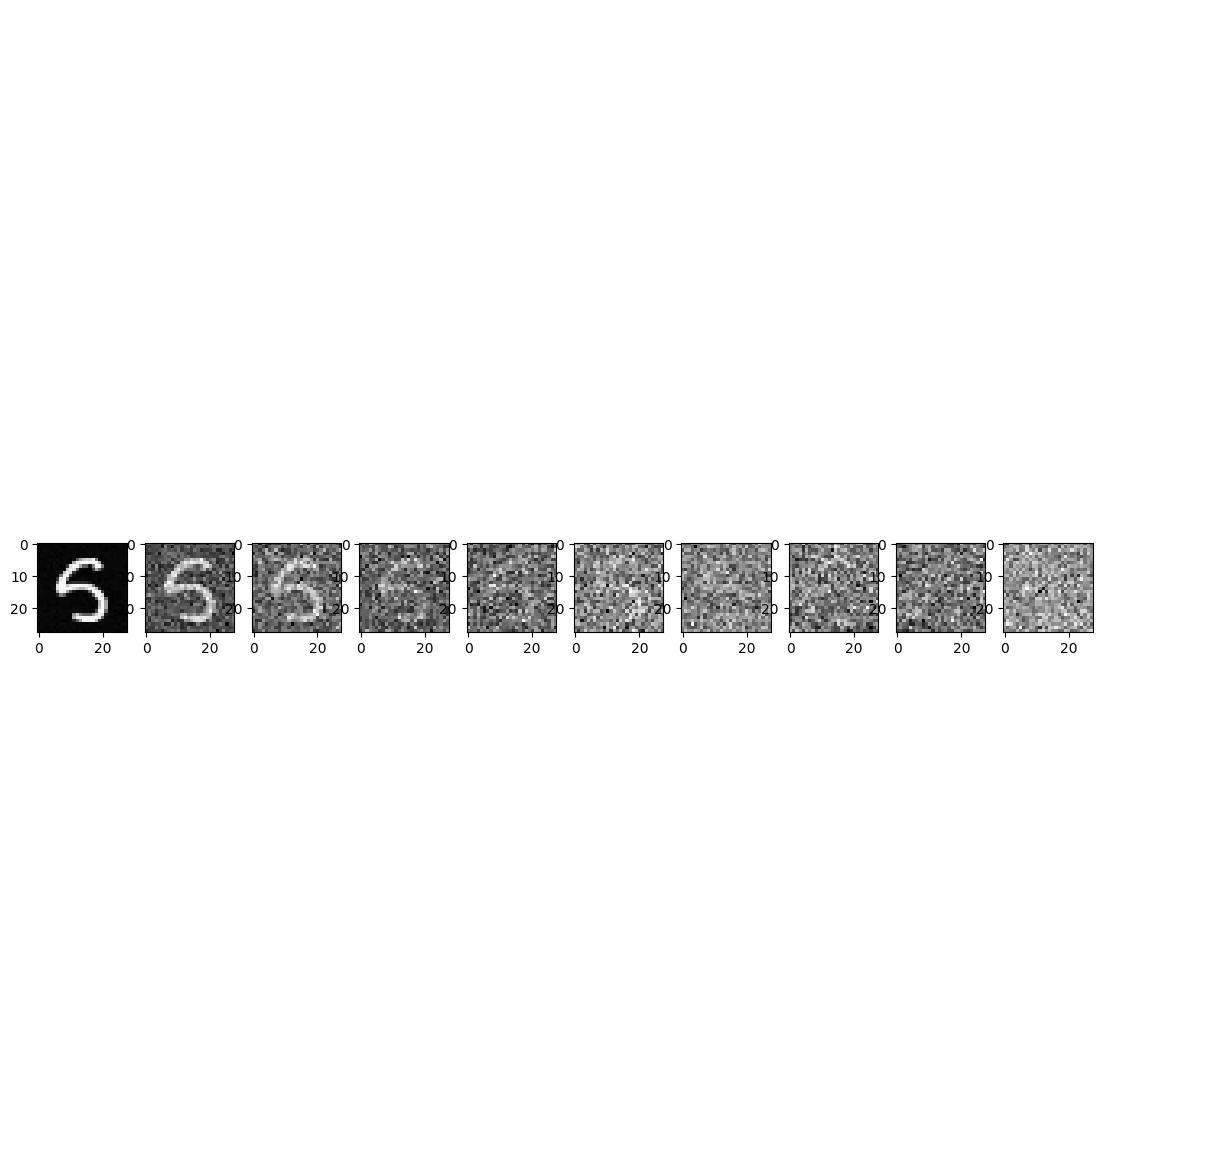

In [34]:
# Simulate forward diffusion
image = next(iter(train_loader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

### Step 2: The backward process

![](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_reverse_diffusion_process-1024x173.png)

In original paper U-net is used to facilitate the backward/reverse process.
For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Notes**:
- We use a simple stacked-convolution model with various dilations instead of UNet-like architecture to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding




#### Sinusoidal embedding for diffusion timestep

In [35]:
class SinusoidalPosEmb(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, x):
    device = x.device
    half_dim = self.dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = x[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

#### Stacked-convolution model (instead of U-net)

In [36]:
class ConvBlock(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0., stride=1,
                 padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y

In [37]:
class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                        activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)


    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)

        y = self.out_project(y)

        return y

denoiser_model = Denoiser(image_resolution=img_size,
                          hidden_dims=hidden_dims,
                          diffusion_time_embedding_dim=timestep_embedding_dim,
                          n_times=n_timesteps).to(device)

In [38]:
denoiser_model

Denoiser(
  (time_embedding): SinusoidalPosEmb()
  (in_project): ConvBlock(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_project): Sequential(
    (0): ConvBlock(
      256, 256, kernel_size=(1, 1), stride=(1, 1)
      (activation_fn): SiLU()
    )
    (1): ConvBlock(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (convs): ModuleList(
    (0): ConvBlock(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-2): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (3-4): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (5-6): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), dilation=(9, 9)
      (activation_fn): SiLU()
      (group_norm): Gro

## Full Diffusion Model (foward + reverse process)
![](https://i.imgur.com/S7KH5hZ.png)

In [39]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon


    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon/noise given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon


    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise / epsilon to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion_model = Diffusion(denoiser_model, image_resolution=img_size, n_times=n_timesteps,
                            beta_minmax=beta_minmax, device=device).to(device)
lr = 5e-5
optimizer = Adam(diffusion_model.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [40]:
diffusion_model

Diffusion(
  (model): Denoiser(
    (time_embedding): SinusoidalPosEmb()
    (in_project): ConvBlock(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_project): Sequential(
      (0): ConvBlock(
        256, 256, kernel_size=(1, 1), stride=(1, 1)
        (activation_fn): SiLU()
      )
      (1): ConvBlock(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (convs): ModuleList(
      (0): ConvBlock(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1-2): 2 x ConvBlock(
        256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (activation_fn): SiLU()
        (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
      )
      (3-4): 2 x ConvBlock(
        256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3)
        (activation_fn): SiLU()
        (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
      )
      (5-6): 2 x ConvBlock(
        256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), d

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)
![](https://huggingface.co/blog/assets/78_annotated-diffusion/training.png)

In [41]:
denoiser_model.train()
epochs = 3

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(device)

        noisy_input, epsilon, pred_epsilon = diffusion_model(x)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\t[Epoch", epoch + 1, "]\tDenoising Loss: ", noise_prediction_loss / batch_idx)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [09:04<00:00,  1.16s/it]


	[Epoch 1 ]	Denoising Loss:  0.09988294122342625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [09:17<00:00,  1.19s/it]


	[Epoch 2 ]	Denoising Loss:  0.03965247416884726


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [10:49<00:00,  1.38s/it]

	[Epoch 3 ]	Denoising Loss:  0.034882795682543107


## Results visualization and Generating Images

In [45]:
# Take one batch from testset
denoiser_model.eval()

with torch.no_grad():
    generated_images = diffusion_model.sample(N=10)

def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

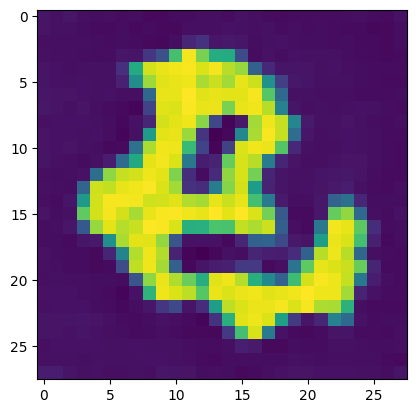

In [46]:
show_image(generated_images, idx=0)

# Resources
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)
- [An In-Depth Guide to Denoising Diffusion Probabilistic Models - From Theory to Implementation](https://learnopencv.com/denoising-diffusion-probabilistic-models/)
- [A Survey on Generative Diffusion Model](https://arxiv.org/pdf/2209.02646.pdf)
